# LSTM ile Hisse Senedi Fİyatı Tahminlemesi

In [18]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns 

end_date =  '2021-06-29'
start_date = '2010-01-01'

stockname = 'Tesla'
symbol = 'TSLA'

import yfinance as yf 
df = yf.download(symbol, start=start_date, end=end_date)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [19]:
df = df.reset_index()

In [20]:
df.columns = df.columns.str.lower()

In [21]:
df.head()

,date,open,high,low,close,adj close,volume
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [22]:
df['date'] = df['date'].dt.strftime('%Y/%m/%d')

In [23]:
df.head()

,date,open,high,low,close,adj close,volume
0,2010/06/29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010/06/30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010/07/01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010/07/02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010/07/06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [24]:
df.dtypes

date          object
open         float64
high         float64
low          float64
close        float64
adj close    float64
volume         int64
dtype: object

Objeyi tarihe çevirmeliyiz

In [25]:
df["date"] = pd.to_datetime(df["date"])

In [26]:
tesla_df = df[["date","close"]]

In [27]:
tesla_df.head()

,date,close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000


In [28]:
tesla_df.index = tesla_df["date"]

In [30]:
tesla_df.drop("date",axis = 1,inplace=True)

C:\Users\Mustafa\AppData\Local\Temp\ipykernel_3516\1184339053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_df.drop("date",axis = 1,inplace=True)


In [31]:
tesla_df

,close
date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2021-06-22,207.903336
2021-06-23,218.856674
2021-06-24,226.606674


In [32]:
result_df = tesla_df.copy()

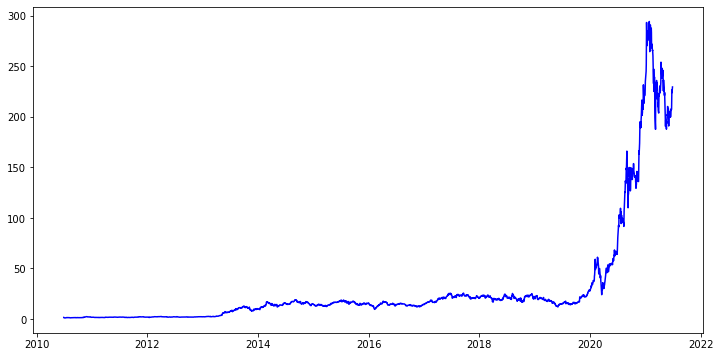

In [34]:
plt.figure(figsize = (12,6))
plt.plot(tesla_df["close"],color = "blue")
plt.show()

In [35]:
tesla_df = tesla_df.values

In [36]:
tesla_df[0:5]

array([[1.59266698],
       [1.58866704],
       [1.46399999],
       [1.27999997],
       [1.074     ]])

In [37]:
tesla_df = tesla_df.astype("float32")

### Train TestSeti Ayrımı

In [38]:
def split_data(dataframe,test_size):
    pos = int(round(len(dataframe)*(1-test_size)))
    train = dataframe[:pos]
    test = dataframe[pos:]
    return train,test,pos

In [39]:
train,test,pos = split_data(tesla_df,0.20)

In [40]:
train.shape,test.shape

((2215, 1), (554, 1))

### MinMaxScaler ile 0-1 arasında standartlaştırma

In [42]:
scaler_train = MinMaxScaler(feature_range = (0,1))

In [43]:
train = scaler_train.fit_transform(train)

In [44]:
scaler_test = MinMaxScaler(feature_range = (0,1))

In [45]:
test = scaler_train.fit_transform(test)

In [46]:
train[0:5]

array([[0.02191227],
       [0.02174976],
       [0.01668474],
       [0.00920911],
       [0.00083967]], dtype=float32)

In [47]:
test[0:5]

array([[0.02177751],
       [0.02225668],
       [0.01977585],
       [0.0200473 ],
       [0.01881042]], dtype=float32)

In [48]:
def create_features(data,lookback):
    X,Y = [],[]
    for i in range(lookback,len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
        
    return np.array(X),np.array(Y)

In [49]:
lookback = 20

In [50]:
X_train,y_train = create_features(train,lookback)

In [51]:
X_test,y_test = create_features(test,lookback)

In [53]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2195, 20), (534, 20), (2195,), (534,))

In [55]:
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [56]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2195, 1, 20), (534, 1, 20), (2195, 1), (534, 1))

## Modellleme

In [59]:
model = Sequential()

model.add(LSTM(units = 50,activation = "relu" ,input_shape=(X_train.shape[1], lookback))) 
model.add(Dropout(0.2))
model.add(Dense(1))

In [60]:
model.compile(optimizer='adam', loss='mse')

In [63]:
callbacks = [EarlyStopping(monitor = "val_loss",patience = 3,verbose = 1,mode = "min"),
             ModelCheckpoint(filepath = "lstmmodel.h5",monitor = "val_loss",mode = "min",save_best_only = True,save_weights_only = False,verbose = 1)]

In [64]:
model.fit(x = X_train,y = y_train,epochs = 100,batch_size = 20,validation_data = (X_test,y_test),callbacks = callbacks,shuffle = False)

Epoch 1/100
104/110 [===========================>..] - ETA: 0s - loss: 0.0057   
Epoch 1: val_loss improved from inf to 0.00214, saving model to lstmmodel.h5
110/110 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0021
Epoch 2/100
104/110 [===========================>..] - ETA: 0s - loss: 0.0053
Epoch 2: val_loss improved from 0.00214 to 0.00157, saving model to lstmmodel.h5
110/110 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 3/100
104/110 [===========================>..] - ETA: 0s - loss: 0.0053   
Epoch 3: val_loss did not improve from 0.00157
110/110 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0016
Epoch 4/100
102/110 [==========================>...] - ETA: 0s - loss: 0.0051
Epoch 4: val_loss improved from 0.00157 to 0.00151, saving model to lstmmodel.h5
110/110 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 5/100
104/110 [===================

In [ ]:
### Loss grafiği çizdir.

## Değerlendirme

In [67]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

17/17 [==============================] - 0s 1ms/step


In [68]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.